<a href="https://colab.research.google.com/github/mu06905/GPU-Accelerated-Programming-in-Cuda-2023/blob/main/Week3/mu06905_Assgn1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## GPU ACCELERATED PROGRAMMING - ASSIGNMENT

Maha Usmani

In [ ]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-9lipb1ol
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-9lipb1ol
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit aac710a35f52bb78ab34d2e52517237941399eff
  Preparing metadata (setup.py) ... done
The nvcc_plugin extension is already loaded. To reload it, use:
  %reload_ext nvcc_plugin


## **QUESTION 1**

We can generate random numbers on the GPU using Both Host and Device APIs. As mentioned in the documentation: by using host API, "the calls to the library are made in the host code but the actual generation of the random numbers happens on the device". Howerver, the Host API can also be used to generate numbers on the host by specifying 'host' in the function calls.

Written in the Documentaion: "Note that curandGenerate() in step 4 above launches a kernel and returns asynchronously."

Reference to Documentation: https://docs.nvidia.com/cuda/curand/host-api-overview.html#host-api-overview

From Nvidia's Developer Website: https://developer.nvidia.com/curand#:~:text=cuRAND%20also%20provides%20two%20flexible,kernels%20running%20on%20the%20GPU.

Flexible usage model: 1) Host API for generating random numbers in bulk on the GPU 2) Inline implementation allows use inside GPU functions/kernels, or in your host code

In [ ]:
%%cuda --name my_curand.cu 
#include <stdio.h>
#include <cuda_runtime.h>
#include <curand.h>

#define CUDA_CALL(x) do { if((x)!=cudaSuccess) { \
    printf("Error at %s:%d\n",__FILE__,__LINE__);\
    return EXIT_FAILURE;}} while(0)
#define CURAND_CALL(x) do { if((x)!=CURAND_STATUS_SUCCESS) { \
    printf("Error at %s:%d\n",__FILE__,__LINE__);\
    return EXIT_FAILURE;}} while(0)

inline cudaError_t checkCudaErr(cudaError_t err, const char* msg) {
  if (err != cudaSuccess) {
    fprintf(stderr, "CUDA Runtime error at %s: %s\n", msg, cudaGetErrorString(err));
  }
  return err;
}
 
int main()
{
  const int N = 1000000;  
  
  float* h_data = (float*)malloc(N * sizeof(float));
  int start_h = clock();
  for(int i=0;i<N;i++)
      h_data[i]=rand()%N;
  int end = clock();
  int time_taken = end - start_h;
  printf("Time taken to populate data on host is %d ms \n",time_taken);

  cudaEvent_t start, stop;
  cudaEventCreate(&start);
  cudaEventCreate(&stop);
  float* d_data;
  curandGenerator_t gen;
  CUDA_CALL(cudaMalloc((void **)&d_data, N*sizeof(float)));
  CURAND_CALL(curandCreateGenerator(&gen, CURAND_RNG_PSEUDO_DEFAULT));
  CURAND_CALL(curandSetPseudoRandomGeneratorSeed(gen, 1234ULL));
  cudaEventRecord(start);
  CURAND_CALL(curandGenerateUniform(gen, d_data, N));
  cudaEventRecord(stop);
  cudaEventSynchronize(stop);
  float milliseconds = 0;
  cudaEventElapsedTime(&milliseconds, start, stop);
  printf("Time taken to populate data on device is %f ms \n",milliseconds);
  start_h = clock();
  CUDA_CALL(cudaMemcpy(h_data, d_data, N * sizeof(float), cudaMemcpyDeviceToHost));
  end = clock();
  time_taken = end - start_h;
  printf("time taken to copy data from gpu to cpu is: %i ms \n",time_taken);

  
  free(h_data);  //deallocate memory on device
  CURAND_CALL(curandDestroyGenerator(gen));
  CUDA_CALL(cudaFree(d_data));


  return 0;
}

'File written in /content/src/my_curand.cu'

In [ ]:
!nvcc -o /content/src/my_curand /content/src/my_curand.cu -lcurand

In [ ]:
!/content/src/my_curand

Time taken to populate data on host is 10022 ms 
Time taken to populate data on device is 0.460800 ms 
time taken to copy data from gpu to cpu is: 877 ms 


## QUESTION 2 


reference:
https://github.com/CoffeeBeforeArch/cuda_programming/blob/master/03_sum_reduction/bank_conflicts/sumReduction.cu

The parallel reduction logic is taken from the above mentioned source.
Details:
Each block contains 250 threads and number of blocks are launched depending on the length of input array using formula: N/250
Inside each kernel function, data from global memory is copied into shared memory which is of size 250. thread sync function is used which waits for each thread to write data in shared memory and helps to prevent race condition. 
On each iteration of the for loop, the number of threads are halved and the stride is multiplied by two. On first iteration, 125 threads will be launched which will add every alternate element of the array in current position. Index would be of sequence 0,2,4,.. 124. Hence after first iteration, we'll get an array in shared memory whose alternating indices (0,2,4 ..124) will be the sum of every pair of elements from the global array. 

After the for loop is executed, the first element of every array in shared memory would contain the sum of 250 elements of the global array. We launch the kernel again to sum over these arrays


In [ ]:
%%cu
#include <stdio.h>
#include "cuda_runtime.h"

inline cudaError_t checkCudaErr(cudaError_t err, const char* msg) {
  if (err != cudaSuccess) {
    fprintf(stderr, "CUDA Runtime error at %s: %s\n", msg, cudaGetErrorString(err));
  }
  return err;
}
//shared memory size
#define SHMEM_SIZE 1000

__global__ void sumReduction(int *v, int *v_r) {
  // Allocate shared memory
  __shared__ int partial_sum[SHMEM_SIZE];

  // Calculate thread ID
  int tid = blockIdx.x * blockDim.x + threadIdx.x;

  // Load elements into shared memory
  
    partial_sum[threadIdx.x] = v[tid];
  
  __syncthreads();

  // Increase the stride of the access until we exceed the CTA dimensions
  for (int s = 1; s < blockDim.x; s *= 2) {
      

        // Change the indexing to be sequential threads
        int index = 2 * s * threadIdx.x;

        // Each thread does work unless the index goes off the block
        if (index < blockDim.x) {
        partial_sum[index] += partial_sum[index + s];
        }
      
    __syncthreads();
  }

  // Let the thread 0 for this block write its result to main memory
  // Result is indexed by this block
  if (threadIdx.x == 0) {
    v_r[blockIdx.x] = partial_sum[0];
  }
}

int main() {
  // Vector size
  const int N = 100000;
  int* initial_host_data = 0;
  int* final_host_data = 0;


  int size = N * sizeof(int);
  initial_host_data = (int*)malloc(N*sizeof(int));
  final_host_data = (int*)malloc(N*sizeof(int));
  for(int i = 0; i<N;i++){
      initial_host_data[i] = 1;
      final_host_data[i] = 0;
  }
  int start = clock() ;
  int sum = 0;
  for(int i = 0;i<N;i++){
      sum+=initial_host_data[i];
  }
  int time_d = clock() - start;
  printf("sum on host %d\n", sum);
  printf("time on cpu is: %d ms\n", time_d);
  int *initial_device_data, *final_device_data;
  checkCudaErr(cudaMalloc((void**)&initial_device_data, size),"malloc");
  checkCudaErr(cudaMalloc((void**)&final_device_data, size),"malloc");

  // Copy to device hv to dv
  checkCudaErr(cudaMemcpy(initial_device_data, initial_host_data, size, cudaMemcpyHostToDevice),"mem copy");
  checkCudaErr(cudaMemcpy(final_device_data, final_host_data, size, cudaMemcpyHostToDevice),"mem copy");

  // TB Size
  const int TB_SIZE = 400;

  // Grid Size (No padding)
  int GRID_SIZE = N / TB_SIZE;

  cudaEvent_t start_d, stop_d;
	cudaEventCreate(&start_d);
	cudaEventCreate(&stop_d);
  // Call kernels
  cudaEventRecord(start_d);
  sumReduction<<<GRID_SIZE, TB_SIZE>>>(initial_device_data, final_device_data);

  sumReduction<<<1, TB_SIZE>>>(final_device_data, final_device_data);
  cudaEventRecord(stop_d);
  cudaEventSynchronize(stop_d);
	float dt = 0;
  cudaEventElapsedTime(&dt, start_d, stop_d);
  printf("Total time on GPU: %f ms\n", dt);
  // Copy to host;
  checkCudaErr(cudaMemcpy(final_host_data, final_device_data, size, cudaMemcpyDeviceToHost),"mem copy");

 printf("sum on gpu = %d", final_host_data[0]);

  //delete data allocated on device
	cudaFree(initial_device_data);
  cudaFree(final_device_data);


	//delete host memory
	free(initial_host_data);
  free(final_host_data);
	cudaDeviceReset();

  return 0;
}

sum on host 100000
time on cpu is: 215 ms
Total time on GPU: 0.045664 ms
sum on gpu = 100000


In [ ]:
import matplotlib.pyplot as plt

The following cell shows the cpu runtime of algorithm an different datasets


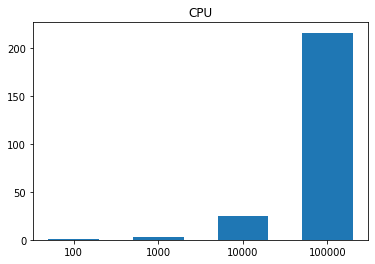

In [ ]:
left_coordinates=[1,2,3,4]
heights = [1,3,25,216]
bar_labels=['100','1000','10000','100000']
plt.title("CPU")
plt.bar(left_coordinates,heights,tick_label=bar_labels,width=0.6)
plt.show()

the following three cells shows the gpu runtime of 1000,10000, 100000 element array against different configurations

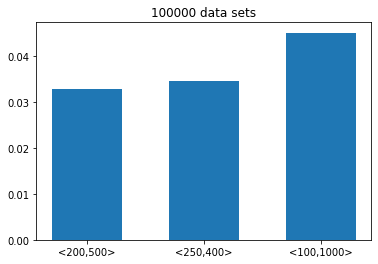

In [ ]:
left_coordinates=[1,2,3]
# heights = [0.040704,0.034464,0.032736]
heights = [0.045120,0.034656,0.032800][::-1]
bar_labels=['<100,1000>','<250,400>','<200,500>'][::-1]
plt.title("100000 data sets")
plt.bar(left_coordinates,heights,tick_label=bar_labels,width=0.6)
plt.show()

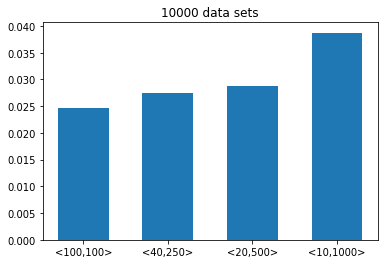

In [ ]:
left_coordinates=[1,2,3,4]
heights=[0.024576,0.027424,0.028864,0.038752]
bar_labels=['<100,100>','<40,250>','<20,500>','<10,1000>']
plt.title("10000 data sets")
plt.bar(left_coordinates,heights,tick_label=bar_labels,width=0.6)
plt.show()


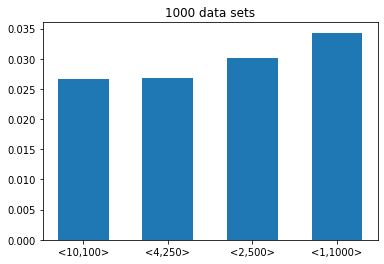

In [ ]:
left_coordinates=[1,2,3,4]
heights=[0.026656, 0.026848, 0.030144,0.034304]
bar_labels=['<10,100>','<4,250>','<2,500>','<1,1000>']
plt.title("1000 data sets")
plt.bar(left_coordinates,heights,tick_label=bar_labels,width=0.6)
plt.show()

# ALTERNATE APPROACH OF QUESTION 2

This appeoach uses atomic add and handles error checking

In [ ]:
%%cu
#include <stdio.h>
#include <time.h>

#define CUDA_CALL(x) do { if((x)!=cudaSuccess) { \
    printf("Error at %s:%d\n",__FILE__,__LINE__);\
    return EXIT_FAILURE;}} while(0)
#define CURAND_CALL(x) do { if((x)!=CURAND_STATUS_SUCCESS) { \
    printf("Error at %s:%d\n",__FILE__,__LINE__);\
    return EXIT_FAILURE;}} while(0)

inline cudaError_t checkCudaErr(cudaError_t err, const char* msg) {
  if (err != cudaSuccess) {
    fprintf(stderr, "CUDA Runtime error at %s: %s\n", msg, cudaGetErrorString(err));
  }
  return err;
}
__global__ void sum_device(int* a, int* sum, const int N) {
	int i = threadIdx.x + blockDim.x * blockIdx.x;
	if (i<N)
		atomicAdd(sum,a[i]);	
	//else 
	//	printf("i > N -> %3d in block: %d\n", i, blockIdx.x);
}

void sum_host(int* a, int* sum, const int N) {
  clock_t clk;

	clk = clock();

	for(int i=0; i<N; ++i)
	  *sum += a[i];

	clk = clock() - clk;
	printf("Total time on CPU: %d ms\n", clk);

}


int main() { 
	int* h_a = 0;
	int sum = 0;
  int* sum_d = 0;
	
	int* d_a = 0;
	int* d_sum;

	const long int N = 1000; 
	int numThreadsPerBlock =  1000;
	int numBlocksPerGrid = ceilf(N/numThreadsPerBlock);
	printf("Num threads per block: %3d\n", numThreadsPerBlock);
	printf("Num blocks per grid: %3d\n", numBlocksPerGrid);

	size_t size = N * sizeof(int);

	//allocate host memory
	h_a = (int*)malloc(size);	 

	//initialize a
	for(int i=0;i<N;++i) {
		h_a[i] = 1;
	}
	//calculate on host 
	sum_host(h_a, &sum, N); 
	printf("Sum host: %d\n", sum); 

  cudaEvent_t start, stop;
	cudaEventCreate(&start);
	cudaEventCreate(&stop);

	//allocate device memory 
	checkCudaErr(cudaMalloc((void**)&d_a, size),"cudamalloc");
  checkCudaErr(cudaMalloc(&d_sum, sizeof(int)),"cudamalloc");
	
	//copy host data to device memory
	checkCudaErr(cudaMemcpy(d_a, h_a, size, cudaMemcpyHostToDevice),"cudamemcopy"); 


	checkCudaErr(cudaEventRecord(start),"event start");
	sum_device<<<numBlocksPerGrid, numThreadsPerBlock>>>(d_a, d_sum, N);
	CUDA_CALL(cudaDeviceSynchronize());
  checkCudaErr(cudaEventSynchronize(stop),"event synchronize");

  

	cudaEventRecord(stop);
	//copy result from device to host
	checkCudaErr(cudaMemcpy(&sum_d, d_sum, sizeof(int), cudaMemcpyDeviceToHost),"cuda memcopy");
  cudaEventSynchronize(stop);
	float dt = 0;
  ;


  printf("Sum (device): %d\n",sum_d);

 
	checkCudaErr(cudaEventElapsedTime(&dt, start, stop),"cuda elapsed time");
	printf("Total time on GPU: %f msecs\n", dt);

	//delete data allocated on device
	cudaFree(d_a);

	//delete host memory
	free(h_a);

	cudaDeviceReset();
	return 0;
}

Num threads per block: 1000
Num blocks per grid:   1
Total time on CPU: 4 ms
Sum host: 1000
Sum (device): 1000
Total time on GPU: 0.026784 msecs

